In [1]:
### Imports, some helper functions
import numpy as np
import xarray as xr
import glob
import os
import hashlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps
from matplotlib import cm
import seaborn as sns
import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pprint import pp

# let's test for now...
from xarray_cacher import *

In [2]:
### Data loading
# Corrected lat-lon grid will be handled separately 
model_grid = xr.open_mfdataset("/data/ycheng46/NNA/data/alaska_climate_region.nc")
static_lat2d = model_grid.lat.values
static_lon2d = model_grid.lon.values % 360

soil_ice_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/soilice_m/*.nc",
                  "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/soilice_m/*.nc",
                  "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/soilice_m/*.nc" ]

soil_liquid_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/soilliq_m/*.nc",
                     "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/soilliq_m/*.nc",
                     "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/soilliq_m/*.nc" ]

qsoil_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/qsoil_m/*.nc",
               "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/qsoil_m/*.nc",
               "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/qsoil_m/*.nc" ]

soil_ice_P, soil_ice_H, soil_ice_M = unpacker(soil_ice_paths, "SOILICE")
soil_liquid_P, soil_liquid_H, soil_liquid_M = unpacker(soil_liquid_paths, "SOILLIQ")
qsoil_P, qsoil_H, qsoil_M = unpacker(qsoil_paths, "QSOIL")

In [3]:
### Data cleanup
## Constants
seconds_per_year = 365.25 * 86400
seconds_per_season = 90.25 * 86400

## Helpers for our cache functions
def compute_annual_generic(ds):
    return ds.groupby("time.year").mean(dim="time", skipna=True, keep_attrs=True)

def compute_annual_runoff(ds):
    return ds.groupby("time.year").mean(dim="time", skipna=True, keep_attrs=True)

def compute_geo_average_future(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sel(year=slice(2034, 2064))

def compute_geo_average_historic(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sel(year=slice(1990, 2020))

def compute_layer_average_future(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sum(dim="levsoi").sel(year=slice(2034, 2064))

def compute_layer_average_historic(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sum(dim="levsoi").sel(year=slice(1990, 2020))

## Soil ice
# these don't change anything, but I'm leaving it here
# so it makes it easy to mass edit if needed later.
total_soil_ice_P = soil_ice_P
total_soil_ice_H = soil_ice_H
total_soil_ice_M = soil_ice_M

annual_soil_ice_P = cache_xarray(compute_annual_generic, total_soil_ice_P, name_hint="annual_soil_ice_P")
annual_soil_ice_H = cache_xarray(compute_annual_generic, total_soil_ice_H, name_hint="annual_soil_ice_H")
annual_soil_ice_M = cache_xarray(compute_annual_generic, total_soil_ice_M, name_hint="annual_soil_ice_M")

# needed for the graphs later
clean_annual_soil_ice_P = cache_xarray(compute_geo_average_historic, annual_soil_ice_P, name_hint="clean_annual_soil_ice_P")
clean_annual_soil_ice_H = cache_xarray(compute_geo_average_future, annual_soil_ice_H, name_hint="clean_annual_soil_ice_H")
clean_annual_soil_ice_M = cache_xarray(compute_geo_average_future, annual_soil_ice_M, name_hint="clean_annual_soil_ice_M")

# needed for the graphs later
annual_soil_ice_numpy_P = cache_xarray(compute_layer_average_historic, annual_soil_ice_P, name_hint="annual_soil_ice_numpy_P")
annual_soil_ice_numpy_H = cache_xarray(compute_layer_average_future, annual_soil_ice_H, name_hint="annual_soil_ice_numpy_H")
annual_soil_ice_numpy_M = cache_xarray(compute_layer_average_future, annual_soil_ice_M, name_hint="annual_soil_ice_numpy_M")

## Soil liquid
# these don't change anything, but I'm leaving it here
# so it makes it easy to mass edit if needed later.
total_soil_liquid_P = soil_liquid_P
total_soil_liquid_H = soil_liquid_H
total_soil_liquid_M = soil_liquid_M

annual_soil_liquid_P = cache_xarray(compute_annual_generic, total_soil_liquid_P, name_hint="annual_soil_liquid_P")
annual_soil_liquid_H = cache_xarray(compute_annual_generic, total_soil_liquid_H, name_hint="annual_soil_liquid_H")
annual_soil_liquid_M = cache_xarray(compute_annual_generic, total_soil_liquid_M, name_hint="annual_soil_liquid_M")

# needed for the graphs later
clean_annual_soil_liquid_P = cache_xarray(compute_geo_average_historic, annual_soil_liquid_P, name_hint="clean_annual_soil_liquid_P")
clean_annual_soil_liquid_H = cache_xarray(compute_geo_average_future, annual_soil_liquid_H, name_hint="clean_annual_soil_liquid_H")
clean_annual_soil_liquid_M = cache_xarray(compute_geo_average_future, annual_soil_liquid_M, name_hint="clean_annual_soil_liquid_M")

# needed for the graphs later
annual_soil_liquid_numpy_P = cache_xarray(compute_layer_average_historic, annual_soil_liquid_P, name_hint="annual_soil_liquid_numpy_P")
annual_soil_liquid_numpy_H = cache_xarray(compute_layer_average_future, annual_soil_liquid_H, name_hint="annual_soil_liquid_numpy_H")
annual_soil_liquid_numpy_M = cache_xarray(compute_layer_average_future, annual_soil_liquid_M, name_hint="annual_soil_liquid_numpy_M")

## Groundwater (soil ice + soil liquid)
total_groundwater_P = soil_ice_P + soil_liquid_P
total_groundwater_H = soil_ice_H + soil_liquid_H
total_groundwater_M = soil_ice_M + soil_liquid_M

# give name for cache function
total_groundwater_P.name = "GROUND_P"
total_groundwater_H.name = "GROUND_H"
total_groundwater_M.name = "GROUND_M"

annual_groundwater_P = cache_xarray(compute_annual_generic, total_groundwater_P, name_hint="annual_groundwater_P")
annual_groundwater_H = cache_xarray(compute_annual_generic, total_groundwater_H, name_hint="annual_groundwater_H")
annual_groundwater_M = cache_xarray(compute_annual_generic, total_groundwater_M, name_hint="annual_groundwater_M")

# needed for the graphs later
annual_groundwater_numpy_P = cache_xarray(compute_layer_average_historic, annual_groundwater_P, name_hint="annual_groundwater_numpy_P")
annual_groundwater_numpy_H = cache_xarray(compute_layer_average_future, annual_groundwater_H, name_hint="annual_groundwater_numpy_H")
annual_groundwater_numpy_M = cache_xarray(compute_layer_average_future, annual_groundwater_M, name_hint="annual_groundwater_numpy_M")

## Ground evaporation
total_qsoil_P = qsoil_P * seconds_per_year
total_qsoil_H = qsoil_H * seconds_per_year
total_qsoil_M = qsoil_M * seconds_per_year

annual_qsoil_P = cache_xarray(compute_annual_generic, total_qsoil_P, name_hint="annual_qsoil_P")
annual_qsoil_H = cache_xarray(compute_annual_generic, total_qsoil_H, name_hint="annual_qsoil_H")
annual_qsoil_M = cache_xarray(compute_annual_generic, total_qsoil_M, name_hint="annual_qsoil_M")

# needed for the graphs later
annual_qsoil_numpy_P = cache_xarray(compute_geo_average_historic, annual_qsoil_P, name_hint="annual_qsoil_numpy_P")
annual_qsoil_numpy_H = cache_xarray(compute_geo_average_future, annual_qsoil_H, name_hint="annual_qsoil_numpy_H")
annual_qsoil_numpy_M = cache_xarray(compute_geo_average_future, annual_qsoil_M, name_hint="annual_qsoil_numpy_M")

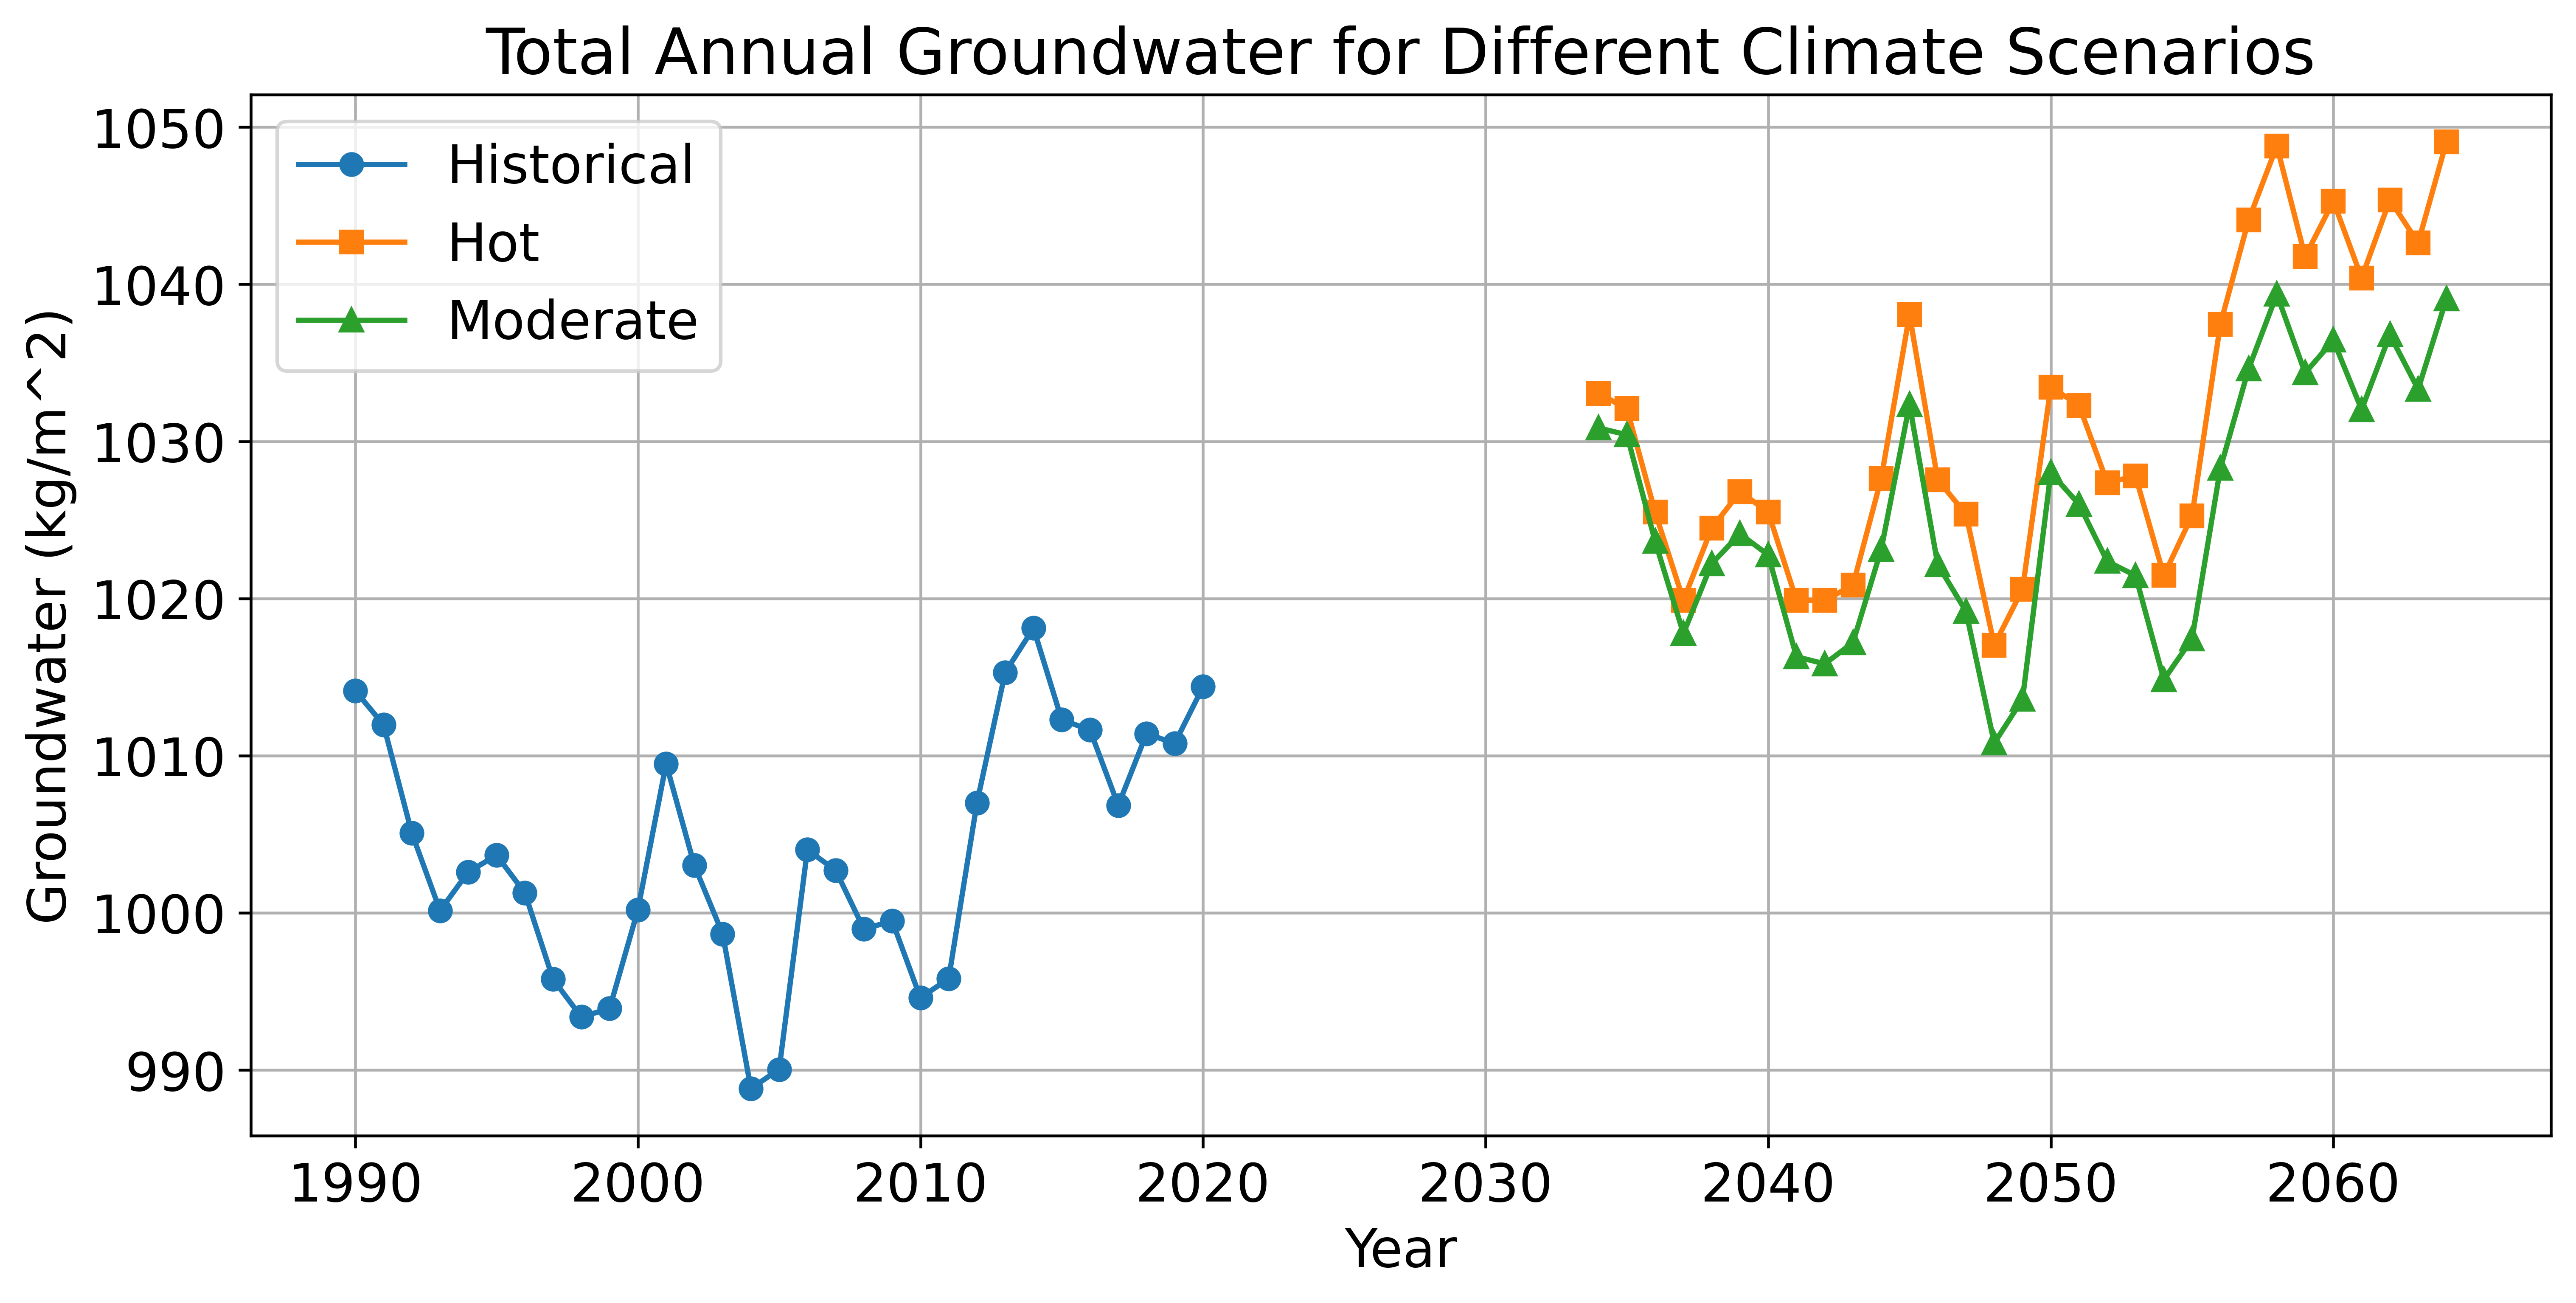

In [4]:
### Data visualization: total annual groundwater
plt.rc('font', size=15)
plt.figure(figsize=(10,5), dpi=600, constrained_layout=True)
plt.plot(annual_groundwater_numpy_P.year.values, annual_groundwater_numpy_P.values, label="Historical", marker='o', linestyle='-')
plt.plot(annual_groundwater_numpy_H.year.values, annual_groundwater_numpy_H.values, label="Hot", marker='s', linestyle='-')
plt.plot(annual_groundwater_numpy_M.year.values, annual_groundwater_numpy_M.values, label="Moderate", marker='^', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Groundwater (kg/m^2)")
plt.title("Total Annual Groundwater for Different Climate Scenarios")
plt.legend()
plt.grid(True)

## saving this work to disk
os.makedirs("groundwater", exist_ok=True)
plt.savefig(f"groundwater/plot-total-annual-water.png")

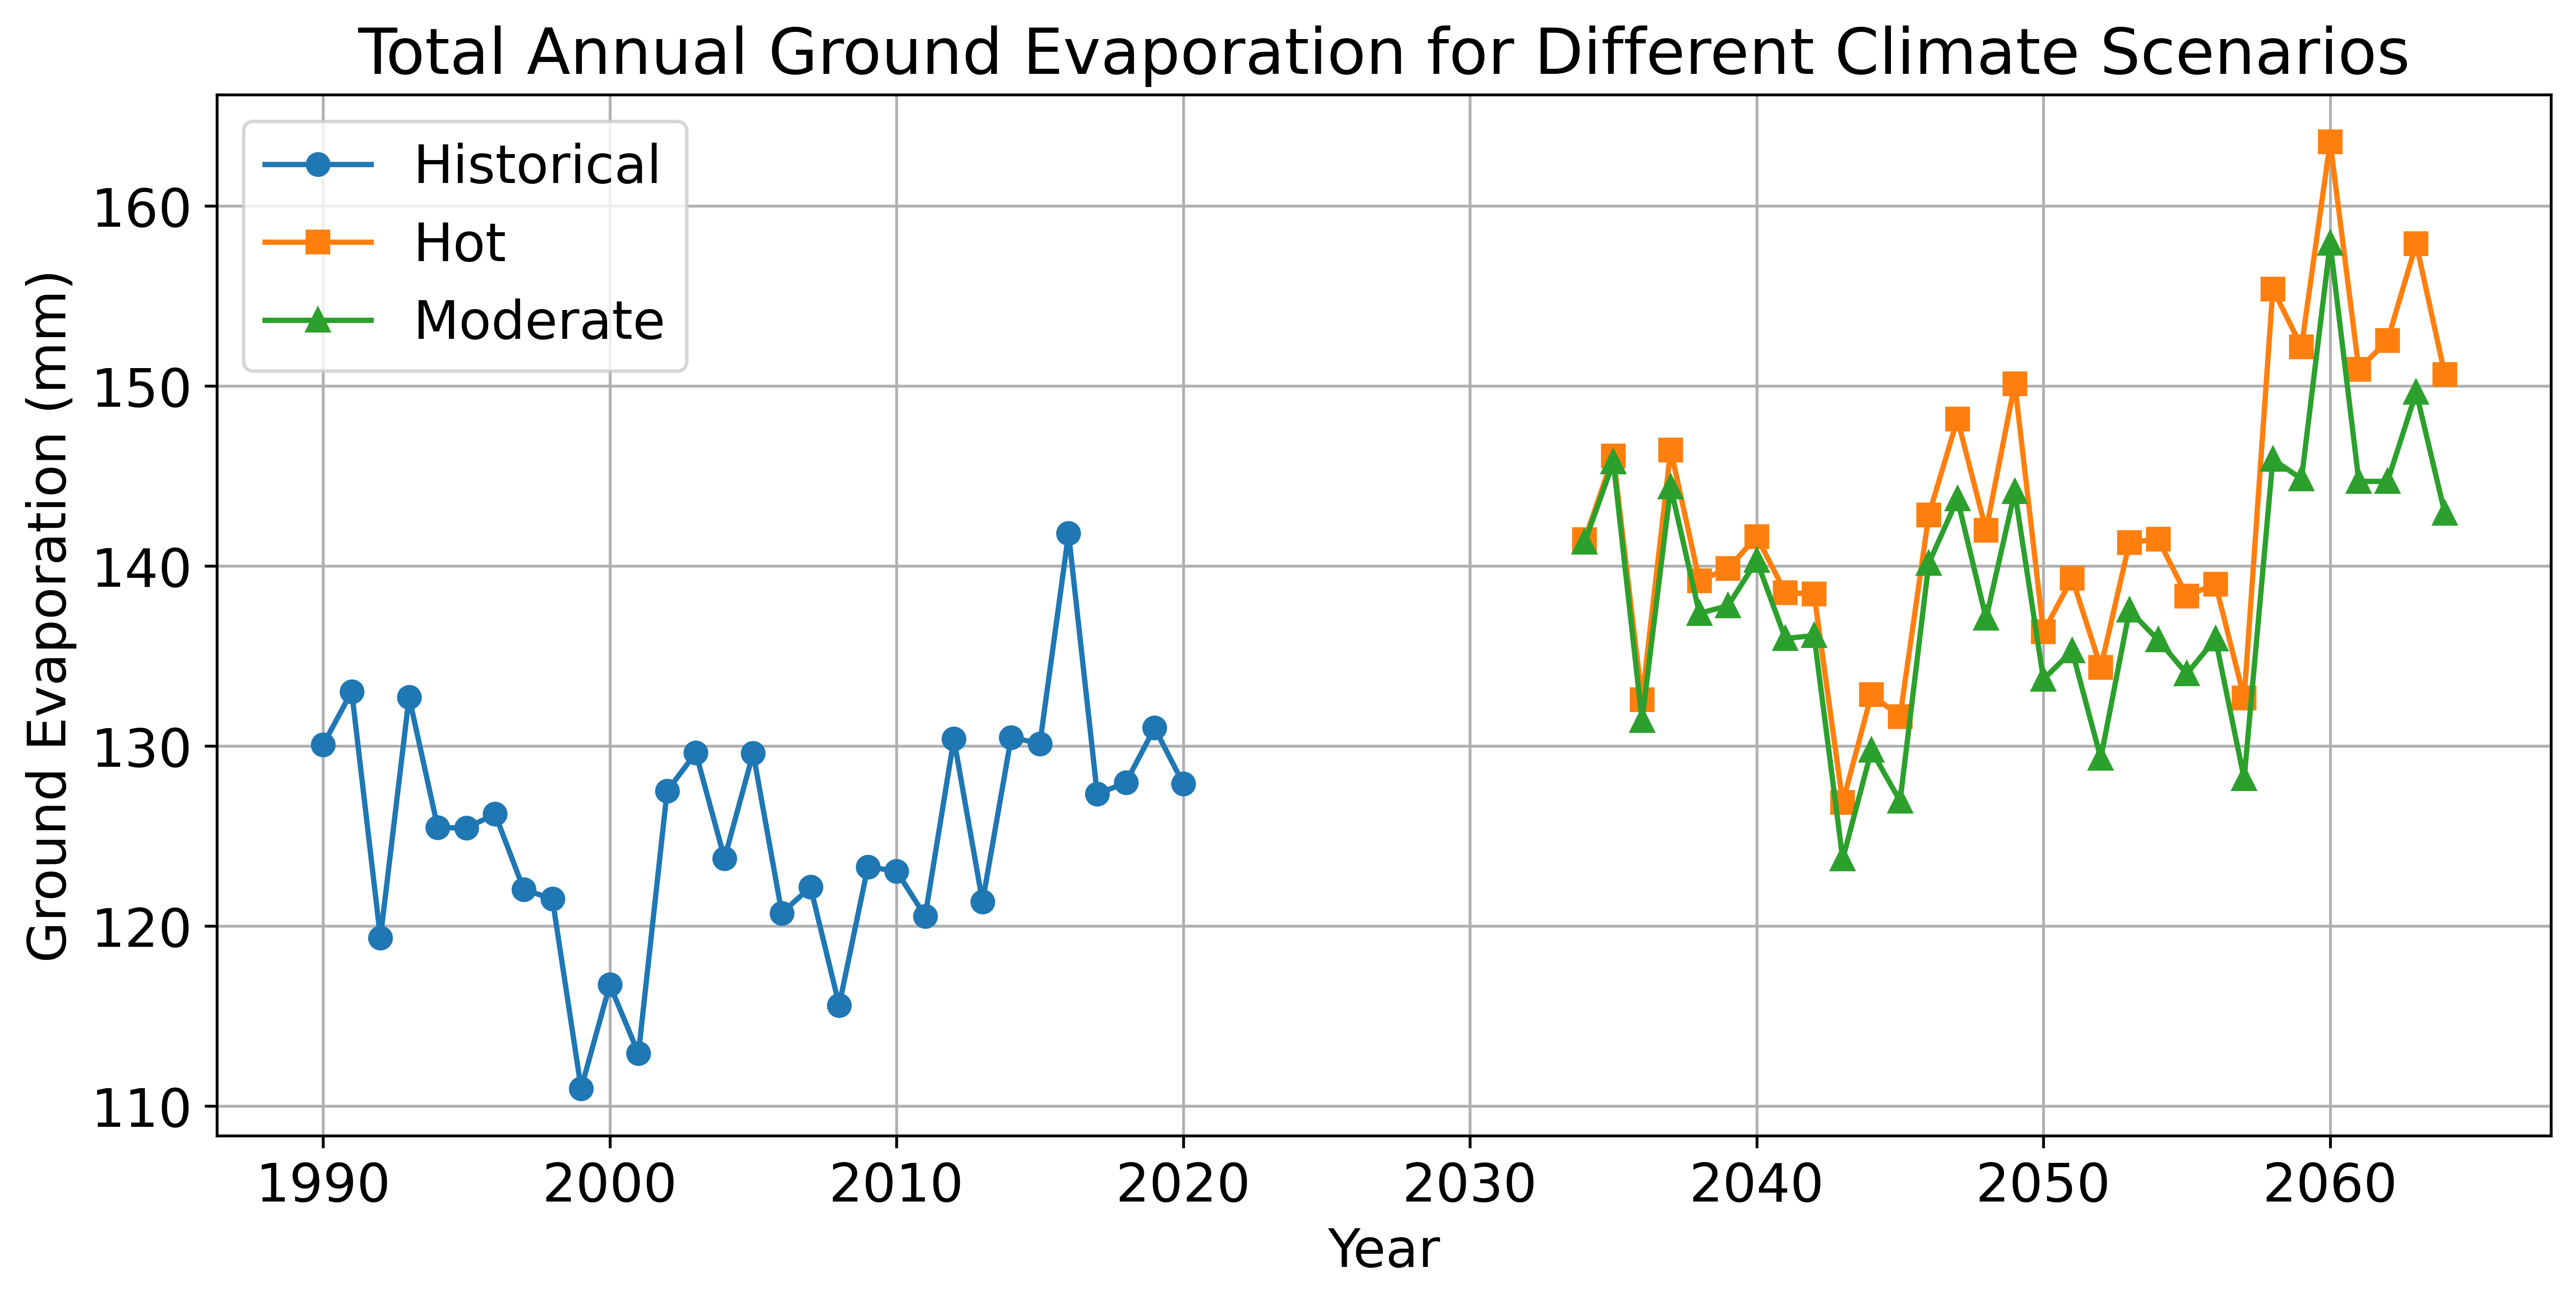

In [5]:
### Data visualization: total annual ground evaporation
plt.rc('font', size=15)
plt.figure(figsize=(10,5), dpi=600, constrained_layout=True)
plt.plot(annual_qsoil_numpy_P.year.values, annual_qsoil_numpy_P.values, label="Historical", marker='o', linestyle='-')
plt.plot(annual_qsoil_numpy_H.year.values, annual_qsoil_numpy_H.values, label="Hot", marker='s', linestyle='-')
plt.plot(annual_qsoil_numpy_M.year.values, annual_qsoil_numpy_M.values, label="Moderate", marker='^', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Ground Evaporation (mm)")
plt.title("Total Annual Ground Evaporation for Different Climate Scenarios")
plt.legend()
plt.grid(True)

## saving this work to disk
os.makedirs("groundwater", exist_ok=True)
plt.savefig(f"groundwater/plot-total-annual-evaporation.png")